# Profiling researchers from trajectory data

Here we introduce algorithms how to profiling based on trajectories data. 
Simplest idea is the plot difference of $\Delta| X(t)- X(t-1)|$ in time.

There are three main types of data:
1. long data (more than 1 year) 
2. middle sized data (1-12 months)
3. short data (shorter than 1 month)


# Data analysis of raw data from trips
We apply three different adaptations of algorithms to these data types based on the lengths of data.

In [1]:

import pandas as pd
import numpy as np

# load the data of trips 

# example data
filepath_before = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/cityBrain/my_trips.csv'
filepath_full = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/cityBrain/trips_updated.csv'

df_full = pd.read_csv(filepath_full)
print(df_full.shape)
print(df_full.columns)
df_full.head()

(2882, 15)
Index(['ctid', 'userid', 'tripid', 'datetimestart', 'datetimestop',
       'latitudestart', 'longitudestart', 'latitudestop', 'longitudestop',
       'averagespeed', 'motionmode', 'durationsec', 'distance',
       'timestampstart', 'timestampstop'],
      dtype='object')


,ctid,userid,tripid,datetimestart,datetimestop,latitudestart,longitudestart,latitudestop,longitudestop,averagespeed,motionmode,durationsec,distance,timestampstart,timestampstop
0,"(0,2)",eu-west-1:644fc1d8-138d-424e-a3bb-65ed317e86ab,fe5e9a6a-b6c4-4004-aa90-5c7c9b5d3a5f,9/25/18 15:53,9/25/18 15:58,48.668435,2.237086,48.668373,2.237038,1.223873,walking,324,0.065103,1537890788,1537891112
1,"(0,3)",eu-west-1:644fc1d8-138d-424e-a3bb-65ed317e86ab,808fd214-58f4-40e8-8339-26fbff83f470,9/25/18 16:29,9/25/18 16:46,48.667619,2.238008,48.714901,2.298308,36.642469,car,1055,10.814846,1537892942,1537893997
2,"(0,4)",eu-west-1:644fc1d8-138d-424e-a3bb-65ed317e86ab,808fd214-58f4-40e8-8339-26fbff83f470,9/25/18 16:46,9/25/18 16:46,48.714893,2.298301,48.714887,2.298306,0.164059,train,5,0.000707,1537894002,1537894007
3,"(0,5)",eu-west-1:644fc1d8-138d-424e-a3bb-65ed317e86ab,808fd214-58f4-40e8-8339-26fbff83f470,9/25/18 16:47,9/25/18 17:3,48.714889,2.298302,48.704187,2.322558,11.361664,car,962,2.801420,1537894025,1537894987
4,"(0,6)",eu-west-1:644fc1d8-138d-424e-a3bb-65ed317e86ab,09c45ba4-489c-49f9-9bfa-7f6040bedf19,9/26/18 15:17,9/26/18 15:33,48.665507,2.237715,48.713246,2.297054,41.910265,car,970,10.663661,1537975059,1537976029


In [8]:
# calculate cumulative duration and distance arrays 

cumulative_duration = np.zeros(df_full.shape[0])
cumulative_distance = np.zeros(df_full.shape[0])

for ind in range(1,df_full.shape[0]):
    cumulative_duration[ind] = cumulative_duration[ind-1] + df_full.durationsec.iloc[ind]
    cumulative_distance[ind] = cumulative_distance[ind-1] + df_full.distance.iloc[ind]

print('done with calculating cumulative arrays')


done with calculating cumulative arrays


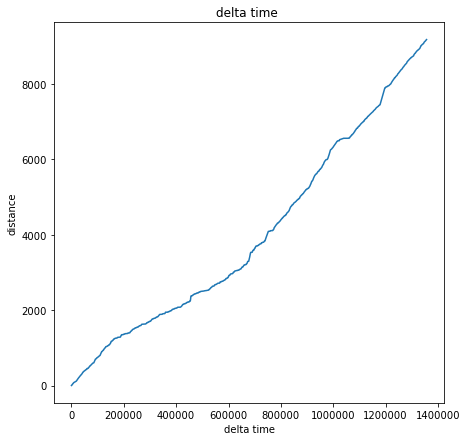

In [9]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

# estimate distance between two sequent trips, plot them in the form of CTRW graph X(t)


f, ax = plt.subplots(figsize=(7, 7))
#ax.set( yscale="log")
plt.plot( cumulative_duration, cumulative_distance)
plt.title('Cumulative plot of distance vs. time')
plt.xlabel('delta time')
plt.ylabel('delta distance')
plt.show()

# Data analysis of well segmented trips
We analyze data after segmentation. 
Let's take trajectory data after segmentation with only main stops of trajectories.
This data is long data ($\approx$ 2 years).

In [3]:
# function to get dataframe from json 


import json
from pprint import pprint


'''
Functions:
 to estimate the distribution of stop duration
 to estimate the distribution of jump length
'''

def duration_stop_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns sorted distribution of stops duration
        Can be misleading for days w/ lots of travel etc. 
    """
    places_of_day = []
    duration_seq = [] #sequence of durations of stops
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            duration_seq.append([duration])
    duration_seq.sort() 
    return duration_seq 

def len_jumps_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns the distribution of jumps lengths (calculated from lat/long of stops)
    can be misleading for days w/ lots of travel etc. 
    """
    places_of_traj = [] #returns array of all locations during the day
    for i in daily_segments: 
        if i['type'] == 'place':
            place_location = i['place']['location']
            places_of_traj.append([place_location])
    return places_of_traj


def longest_daily_location(daily_segments):
    """
    Function from Bastian (Open Humans)
    
    Bastian did analysis of most popular location data in his notebook for Open humans
    https://exploratory.openhumans.org/notebooks/?source=Moves%20connection
    
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]



'''
function to create new dataframe from the json trajectory file
code adapted from openhumans notebook
'''

def dataframe_from_json(moves_data):
    for datapoint in moves_data:
        # we need to have observed segments for that day. If moves wasn't running we ignore the day
        if datapoint['segments'] != None:
            # did we stay in a place that day and did we walk that day?
            has_places = False
            walked = False
            for i in datapoint['segments']:
                if i['type'] == 'place':
                        # yes, we were in one place w/o moving around too much, we can keep this day
                        has_places = True
                        
            # is this day in our date range of interest and has data?
            if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
                moves_processed_data['date'].append(datapoint['date'])
                for activity in datapoint['summary']:
                    if activity['activity'] == 'walking':
                        moves_processed_data['steps'].append(activity['steps'])
                        moves_processed_data['distance'].append(activity['distance'])
                        walked = True
                        
                # in case of not walking, step count is zero
                if not walked:
                    moves_processed_data['steps'].append(0)
                    moves_processed_data['distance'].append(0)  
                    
                # distribution of stops lengths
                stops_distrib = duration_stop_distribution(datapoint['segments'])
                moves_processed_data['duration'].append(stops_distrib)
                location = longest_daily_location(datapoint['segments'])
                moves_processed_data['lat'].append(location['lat'])
                moves_processed_data['lon'].append(location['lon'])    
    
    
    
    #Now that we have all of the data we can convert it into a single pandas dataframe for easier processing and visualization
    
    moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    })   
    
    return moves_dataframe




In [6]:
# main function analyzing moves_data    
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

with open('C:/Users/lyubo/Documents/DATA_networks/mobilitydata/openhumans/moves-storyline-data.json') as f:
    moves_data = json.load(f)
    
with open('C:/Users/lyubo/Documents/DATA_networks/mobilitydata/openhumans/moves-storyline-data98933.json') as f: #uploading different datafiles
    moves_data2 = json.load(f)

#with open('C:/Users/lyubo/Documents/DATA_networks/mobilitydata/openhumans/moves-storyline-data98972.json') as f:
#    moves_data3 = json.load(f)   
    

# function to get data from json data
moves_processed_data = defaultdict(list) #empty dict for processed dataframe

df = dataframe_from_json(moves_data2)  
    


In [10]:
df.head()
  

,date,steps,distance,latitude,longitude
0,20160602,1522,940.0,35.769257,-78.74505
1,20160603,6869,3863.0,35.769257,-78.74505
2,20160617,2827,1907.0,35.769257,-78.74505
3,20160618,6028,4230.0,35.769257,-78.74505
4,20160619,3492,2870.0,35.769257,-78.74505


In [8]:

# Save Numpy array to csv
#np.savetxt('data_OH.csv', df, delimiter=',', fmt='%d')
df.to_csv('data_trajectory_OH.csv')


# Profiling: step 0 
We look at different distributional properties of trips.
We look at how often there are days with steps above some threshold.

In [13]:
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
#import osmnx as ox
from math import sin, cos, sqrt, atan2, radians



def distribut_steps(dataframe):
    steps = dataframe.steps.values
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.distplot(steps)#, bins=20)
    plt.xlabel("steps")
    plt.ylabel("frequency") 
    plt.show()
    
def distribut_distan(dataframe):
    steps = dataframe.distance.values
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.distplot(steps)#, bins=20)
    plt.xlabel("distance")
    plt.ylabel("frequency") 
    plt.show()
    
    
    

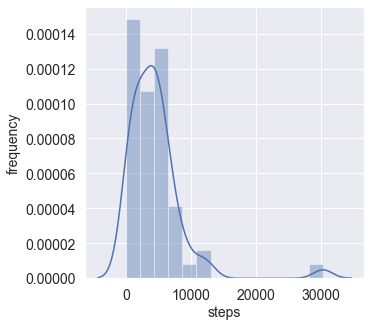

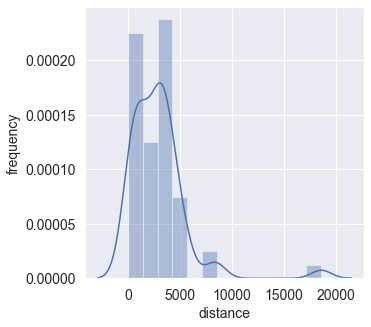

In [14]:
distribut_steps(df)
distribut_distan(df)

# Profiling: step 1 
First we want to identify locations of the most visited places. 
For this we apply clustering algorithm to identify the most visited places. 


In [15]:
# go to notebook "Clustering_trips"


# Profiling: step 2 
Next we identify locations and additional information about these places, 
using osmnx, amenities and differnt euristics. 